## TRAINING

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True 
config.log_device_placement = True
sess = tf.Session(config=config)
set_session(sess)  

from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

import cv2
import os
import pandas as pd
import numpy as np
import json

Using TensorFlow backend.


In [20]:
# DEFINING ALL PARAMETERS

# which videos are used for training and validation, which for testing
train_val_videos = [2, 3, 4, 5, 6, 7]
test_videos = [1]

# path to the database
path = "C:\\Users\\Jelena\\Desktop\\CV\\project\\DB\\"

# frames per second used for training/validation and testing, max is 60
fps_training = 10
fps_testing = 20

rate_training = 60/fps_training
rate_testing = 60/fps_testing

num_of_subjects = 62

# image size in pixels
x = 102
y = 102

scale_factor_x = round(x/512, 2)
scale_factor_y = round(y/512, 2)

In [21]:
# INITIALIZING VARIABLES

training_list = []
testing_list = []

training_label = []
testing_label = []

training_counter = 0
testing_counter = 0

In [22]:
# LOADING DATA

for i in range (1, num_of_subjects+1):   
    for name in os.listdir(path + str(i) + '\\'):
        img = cv2.imread(path + str(i) + '\\' + name)
        
        if(img.size == 786432):
            small = cv2.resize(img, (0,0), fx=scale_factor_x, fy=scale_factor_y)
            video_number = int(name.split('_')[1])
        
            if video_number in train_val_videos:
                if training_counter % rate_training == 0:
                    training_list.append(small)
                    training_label.append(str(i))
                training_counter += 1
        
            elif video_number in test_videos:
                if testing_counter % rate_testing == 0:
                    testing_list.append(small)
                    testing_label.append(str(i))
                testing_counter += 1

In [23]:
training_list = np.array(training_list)
training_label = np.array(training_label)
print("Training: " + str(training_list.shape[0]))

testing_list = np.array(testing_list)
testing_label = np.array(testing_label)
print("Testing: " + str(testing_list.shape[0]))

Training: 7930
Testing: 3634


In [24]:
# NORMALIZING AND SHUFFLING TRAINING DATA

training_list_normalized = training_list.astype('float32')/255.
training_list_normalized = training_list_normalized.reshape(training_list_normalized.shape[0], x*y*3)

training_df = pd.DataFrame(training_list_normalized)
training_labels_df = pd.DataFrame(training_label)
                                 
training_vectors = pd.concat([training_df,training_labels_df], axis=1)
training_vectors_shuffled = shuffle(training_vectors)

In [25]:
# SPLITTING DATA IN TRAINING AND VALIDATION SET

newdf1 = np.random.rand(len(training_vectors_shuffled)) < 0.7
train = training_vectors_shuffled[newdf1]
validation = training_vectors_shuffled[~newdf1]

In [34]:
# SPLITTING FEATURE VECTORS AND LABELS

trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
validationfeatures = validation.iloc[:, :-1]
validationlabel = validation.iloc[:, -1:]

In [35]:
numpy_trainfeatures = trainfeatures.values
numpy_trainfeatures = numpy_trainfeatures.reshape(numpy_trainfeatures.shape[0],x,y,3)
numpy_label = trainlabel.values

numpy_validationfeatures = validationfeatures.values
numpy_validationfeatures = numpy_validationfeatures.reshape(numpy_validationfeatures.shape[0],x,y,3)
numpy_validationlabel = validationlabel.values

In [36]:
# LABELS TO CATEGORICAL

lb = LabelEncoder()

numpy_trainlabel = np_utils.to_categorical(lb.fit_transform(numpy_label.ravel()))
numpy_validationlabel = np_utils.to_categorical(lb.fit_transform(numpy_validationlabel.ravel()))

In [37]:
# BUILDING THE MODEL

def build_cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(102,102,3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(68, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(68, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.15))
    
    model.add(Flatten())
    
    #model.add(Dropout(0.25))
    #model.add(Dense(64, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.15))
    
    model.add(Dense(62,activation='softmax'))

    #opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    
    return model

In [38]:
cnn_model = build_cnn_model()
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 68)        19652     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 68)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 24, 24, 68)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 22, 22, 68)        41684     
__________

In [39]:
cnn_hist = cnn_model.fit(numpy_trainfeatures , numpy_trainlabel, epochs=100, batch_size=128, validation_data=(numpy_validationfeatures, numpy_validationlabel))

Train on 5608 samples, validate on 2322 samples
Epoch 1/100
5608/5608 [==============================] - 63s 11ms/step - loss: 4.0354 - acc: 0.0448 - val_loss: 3.7961 - val_acc: 0.0952
Epoch 2/100
5608/5608 [==============================] - 20s 4ms/step - loss: 2.9690 - acc: 0.2603 - val_loss: 2.0670 - val_acc: 0.4815
Epoch 3/100
5608/5608 [==============================] - 20s 4ms/step - loss: 1.9375 - acc: 0.4905 - val_loss: 1.3886 - val_acc: 0.6761
Epoch 4/100
5608/5608 [==============================] - 20s 4ms/step - loss: 1.3168 - acc: 0.6480 - val_loss: 0.9193 - val_acc: 0.7817
Epoch 5/100
5608/5608 [==============================] - 21s 4ms/step - loss: 0.9052 - acc: 0.7525 - val_loss: 0.6898 - val_acc: 0.8333
Epoch 6/100
5608/5608 [==============================] - 20s 4ms/step - loss: 0.6386 - acc: 0.8199 - val_loss: 0.5409 - val_acc: 0.8712
Epoch 7/100
5608/5608 [==============================] - 20s 4ms/step - loss: 0.5017 - acc: 0.8611 - val_loss: 0.6391 - val_acc: 0.8290

5608/5608 [==============================] - 20s 4ms/step - loss: 0.0252 - acc: 0.9941 - val_loss: 0.3761 - val_acc: 0.9470
Epoch 61/100
5608/5608 [==============================] - 20s 4ms/step - loss: 0.0108 - acc: 0.9973 - val_loss: 0.4945 - val_acc: 0.9341
Epoch 62/100
5608/5608 [==============================] - 20s 4ms/step - loss: 0.0203 - acc: 0.9947 - val_loss: 0.3616 - val_acc: 0.9457
Epoch 63/100
5608/5608 [==============================] - 20s 4ms/step - loss: 0.0195 - acc: 0.9957 - val_loss: 0.3723 - val_acc: 0.9513
Epoch 64/100
5608/5608 [==============================] - 20s 3ms/step - loss: 0.0129 - acc: 0.9952 - val_loss: 0.4465 - val_acc: 0.9462
Epoch 65/100
5608/5608 [==============================] - 19s 3ms/step - loss: 0.0197 - acc: 0.9945 - val_loss: 0.4109 - val_acc: 0.9518
Epoch 66/100
5608/5608 [==============================] - 20s 4ms/step - loss: 0.0144 - acc: 0.9959 - val_loss: 0.4139 - val_acc: 0.9488
Epoch 67/100
5608/5608 [==============================

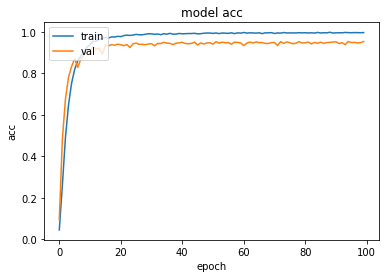

In [40]:
# PLOTTING ACCURACY

plt.plot(cnn_hist.history['acc'])
plt.plot(cnn_hist.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('final_acc.png', bbox_inches='tight')
plt.show()

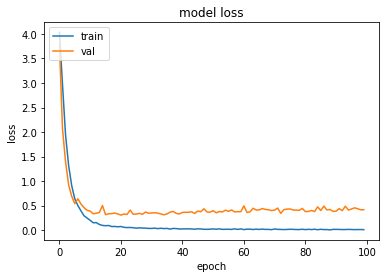

In [41]:
# PLOTTING LOSS

plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('final_loss.png', bbox_inches='tight')
plt.show()

In [42]:
# PREPARING TESTING DATA

testing_list = testing_list.astype('float32')/255.

lb = LabelEncoder()
testing_label = np_utils.to_categorical(lb.fit_transform(testing_label.ravel()))                                    

In [43]:
# EVALUATING THE MODEL

result = cnn_model.evaluate(testing_list, testing_label, verbose=0)
print ("%s: %.2f%%" % (cnn_model.metrics_names[1], result[1]*100))

acc: 86.08%


In [44]:
# SAVING THE MODEL

model_name = 'final_model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
    
model_path = os.path.join(save_dir, model_name)
cnn_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_json = cnn_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Saved trained model at C:\Users\Jelena\Desktop\CV\project\saved_models\final_model.h5 


In [45]:
# PREDICTING WITHOUT LABELS AND SAVING TO .CSV FILE

preds = cnn_model.predict(testing_list, batch_size=32, verbose=1)

max_percentage_predictions = preds.argmax(axis=1)
flatten_predictions = max_percentage_predictions.astype(int).flatten()

predictions = (lb.inverse_transform((flatten_predictions)))
predictions_df = pd.DataFrame({'predictedvalues': predictions})

true_values = testing_label.argmax(axis=1)
flatten_true_values = true_values.astype(int).flatten()

true_values = (lb.inverse_transform((flatten_true_values)))
true_values_df = pd.DataFrame({'actualvalues': true_values})

predictions_and_truevalues = true_values_df.join(predictions_df)
predictions_and_truevalues.to_csv('Predictions.csv', index=False)

3634/3634 [==============================] - 15s 4ms/step
